# Train

In [1]:
import torch
import numpy as np
import scipy.io
import time
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.autograd import Variable, grad
from torch.optim import Adam, LBFGS, RMSprop
from torch.nn import Parameter

from latentpinn.utils import *
from latentpinn.model import *

plt.style.use("../science.mplstyle")

from torch.utils.tensorboard import SummaryWriter
    
np.random.seed(12345678)
torch.manual_seed(12345678)

train_latent = torch.load('../data/train_latent_reseam.pt').cuda()
train_latent = train_latent/abs(train_latent).max()

train_vel = np.load('../data/train_vel_reseam.npy')[:,::2,::2][:,:101,:101]

# Parameters setting
fre = 3.0 # Hz
PI = 3.14159
omega = 2.0 * PI * fre
radius = [10e2]
alphas = [1e4]
num_vel= 1000 #00
niter = 900000 # * num_vel
nz = 101
nx = 101
misfit = []
misfit1 = []

layers = [27+train_latent.shape[1], 64, 64, 32, 32, 16, 16, 8, 8, 2]

# Load analytical wavefield solutions
test_data = scipy.io.loadmat('../data/test_data_3Hz_reseam.mat')
dU_real_star = test_data['dU_real_star'].reshape(2001,-1,1)
d0_real_star = test_data['d0_real_star'].reshape(2001,-1,1)
dU_imag_star = test_data['dU_imag_star'].reshape(2001,-1,1)
d0_imag_star = test_data['d0_imag_star'].reshape(2001,-1,1)
v_star = test_data['v_star'].reshape(2001,-1,1)

x_star = test_data['x_star'].reshape(-1,1)
z_star = test_data['z_star'].reshape(-1,1)
sx_star = test_data['sx_star'].reshape(-1,1)

train_data = scipy.io.loadmat('../data/train_data_3Hz_reseam.mat')

u0_real_train_all = train_data['U0_real_train'].reshape(2001,-1,1)
u0_imag_train_all = train_data['U0_imag_train'].reshape(2001,-1,1)
x_train_all = train_data['x_train'].reshape(2001,-1,1)
y_train_all = train_data['z_train'].reshape(2001,-1,1)
sx_train_all = train_data['sx_train'].reshape(2001,-1,1)
m_train_all = train_data['m_train'].reshape(2001,-1,1)
m0_train_all = train_data['m0_train'].reshape(2001,-1,1)

embedding_fn_g, input_cha_g = get_embedder1(4,3,0)

np.random.seed(1234)
torch.manual_seed(1234)

model = PhysicsInformedNN(layers)
model.apply(weight_init)
model.cuda()
model = torch.nn.DataParallel(model, device_ids=[0])
cudnn.benchmark = True

## Uncomment to train

# sw = SummaryWriter(comment='Retry n1k per3 e900k velocities with all boundary.')

# for radii in radius:

#     for alpha in alphas:

#         if(1):
#             model = PhysicsInformedNN(layers)
#             model.apply(weight_init)
#             model.cuda()
#             model = torch.nn.DataParallel(model, device_ids=[0])
#             cudnn.benchmark = True

#             # Load data
#             X = np.concatenate([x_train_all,y_train_all,sx_train_all],2)
#             lb_all = torch.FloatTensor(X.min(1)).cuda()
#             ub_all = torch.FloatTensor(X.max(1)).cuda()
#             X = torch.FloatTensor(X)
#             x_train = torch.FloatTensor(X[:,:,0:1]).cuda()
#             y_train = torch.FloatTensor(X[:,:,1:2]).cuda()
#             sx_train =torch.FloatTensor(X[:,:,2:3]).cuda()
#             u0_real_train = torch.FloatTensor(u0_real_train_all).cuda()
#             u0_imag_train = torch.FloatTensor(u0_imag_train_all).cuda()
            
#             x_bc = torch.FloatTensor(x_star.reshape(9,101,101)).cuda()
#             z_bc = torch.FloatTensor(z_star.reshape(9,101,101)).cuda()
#             sx_bc = torch.FloatTensor(sx_star.reshape(9,101,101)).cuda()
#             dur_bc = torch.FloatTensor(data['dU_real_star'].reshape(-1,9,101,101)).cuda()
#             dui_bc = torch.FloatTensor(data['dU_imag_star'].reshape(-1,9,101,101)).cuda()

#             pinn_train(model,x_train,y_train,sx_train, 
#                        u0_real_train, u0_imag_train,
#                        lb_all,ub_all,
#                        m_train_all,m0_train_all,
#                        omega,niter,embedding_fn_g,fre,
#                        x_bc, z_bc, sx_bc, dur_bc, dui_bc, 'all',
#                        num_vel,train_latent,alpha,radii)

#             # Save model
#             state = {
#                 'net':model.module,
#                 'lb':lb_all.cpu().numpy(),
#                 'ub':ub_all.cpu().numpy(),
#             }
#             torch.save(state,sw.log_dir+'/lpe_pinnmodel_all_n30'+str(alpha)+str(radii)+'.tz')

2023-12-13 15:10:38.836656: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 15:10:38.877030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 15:10:38.877061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 15:10:38.878615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 15:10:38.886386: I tensorflow/core/platform/cpu_feature_guar

# Inference

In [2]:
xmin, xmax, zmax, zmin = 0, 2.5, 0, 2.5

def plot_square_image(array, height, width=4, name=None, save_dir=None, unit=None, **kwargs):
    
    fig, ax = plt.subplots(height, width, sharex=True, sharey=True, figsize=(int(1.5*height), int(1.5*height)), layout="constrained")

    axs = ax.ravel()
    
    idx = 0
    # for i in [6,7,9,16,21,28,29,43]:
    # for i in [6,7,9,29,43]:
    for i in range(width*height):
        im = axs[idx].imshow(array[i,:,:].T, extent=[xmin, xmax, zmax, zmin], aspect='auto', **kwargs)
        axs[idx].set_xticklabels([])
        axs[idx].set_yticklabels([])
        idx+=1
        
    fig.supxlabel('Lateral Location (km)', fontsize=20)
    fig.supylabel('Depth (km)', fontsize=20)
        
    cbar = fig.colorbar(im, ax=ax[:, -1])#, ax=ax[-1, :], orientation="horizontal", shrink=0.6, location='bottom', pad=2)
    cbar.set_label('km/s', size=20)
    cbar.ax.tick_params(labelsize=20) 
    if name is not None:
        plt.savefig(save_dir+'/'+name)
        
    # plt.tight_layout()
    
    plt.show()

In [3]:
s_idx = 5

idxs = [2,3,4,5,7,9,10,14,16,18,22,23,26,28,35,39]
s_idxs = [0,2,4,8,0,2,4,8,0,2,4,8,0,2,4,8]
# idxs = np.arange(16)


v_test = v_star.reshape(-1,9,101,101)[idxs,s_idxs,:,:]#[-25:]
dU_real_test = dU_real_star.reshape(-1,9,101,101)[idxs,s_idxs,:,:]#[-25:]
dU_imag_test = dU_imag_star.reshape(-1,9,101,101)[idxs,s_idxs,:,:]#[-25:]
dU_real_pred, dU_imag_pred, dU_real_error, dU_imag_error = np.ones_like(v_test),np.ones_like(v_test),np.ones_like(v_test),np.ones_like(v_test)

lb = torch.FloatTensor(torch.load('../saves/result.tz')['lb']).cuda()
ub = torch.FloatTensor(torch.load('../saves/result.tz')['ub']).cuda()
model_pred = torch.load('../saves/result.tz')['net']
model_pred.cuda()

for idx in range(len(idxs)):

    # s_idx = np.random.randint(3)*4

    temp_real, temp_imag = pinn_predict(
        model_pred,torch.FloatTensor(x_star).cuda(),
        torch.FloatTensor(z_star).cuda(), 
        torch.FloatTensor(sx_star).cuda(),
        lb[idxs[idx]],ub[idxs[idx]],
        embedding_fn_g,1,
        train_latent[idxs[idx]]
    )
    dU_real_pred[idx], dU_imag_pred[idx] = temp_real.reshape(9,101,101)[s_idxs[idx],:,:].detach().cpu().numpy(), temp_imag.reshape(9,101,101)[s_idxs[idx],:,:].detach().cpu().numpy()
    
    # Error
    dU_real_error[idx] = (dU_real_test[idx]-dU_real_pred[idx])#/np.linalg.norm(dU_real_star[idx],2)
    dU_imag_error[idx] = (dU_imag_test[idx]-dU_imag_pred[idx])#/np.linalg.norm(dU_imag_star[idx],2)

# Plots

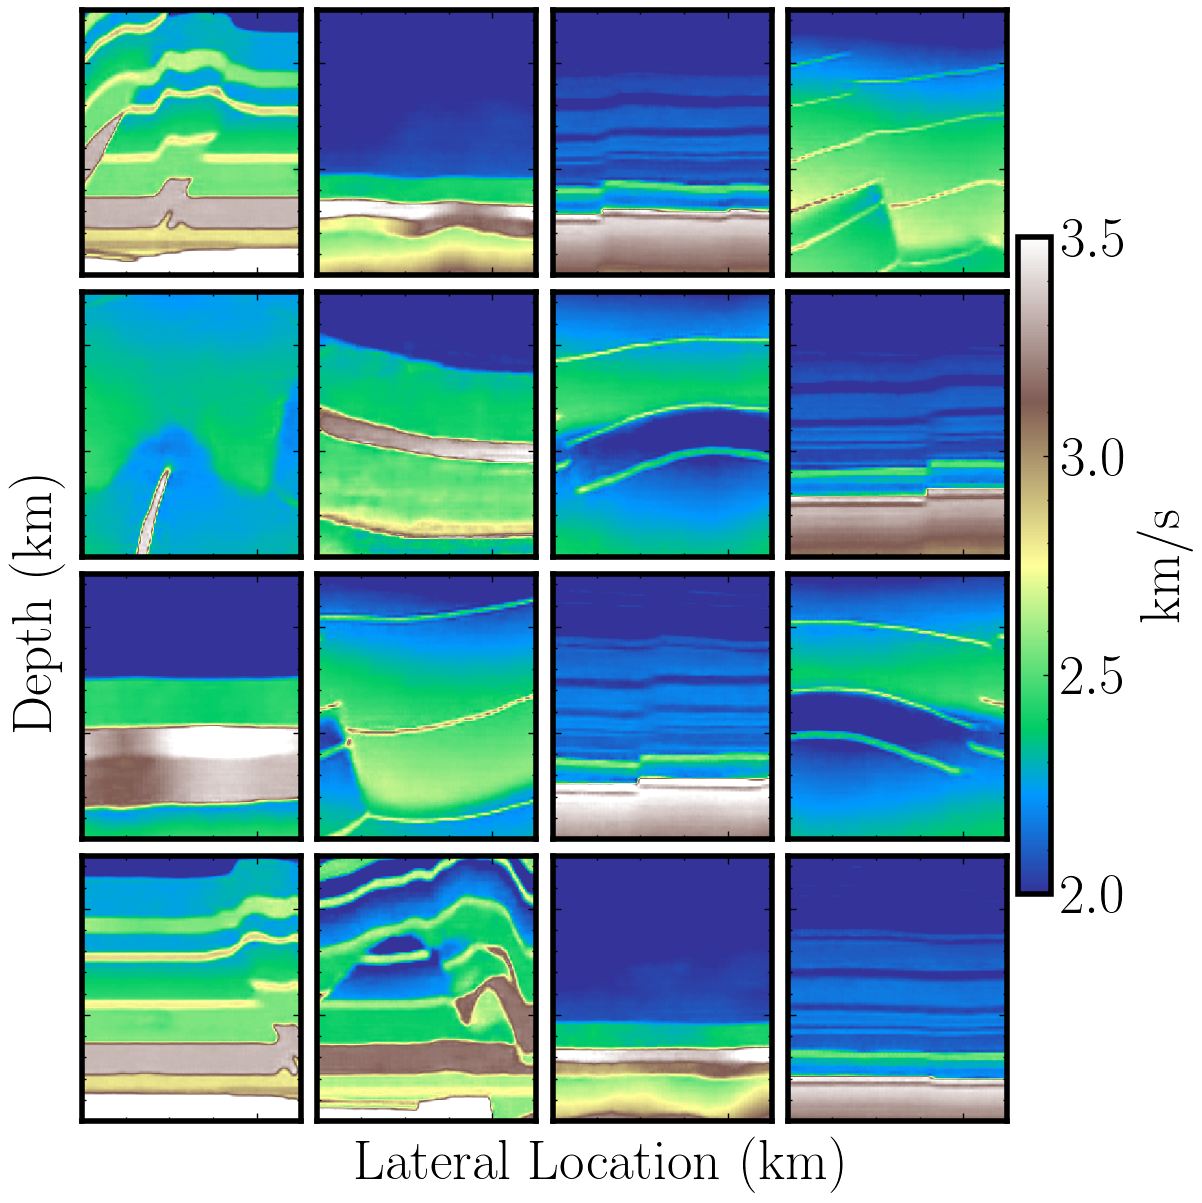

In [4]:
plot_square_image(v_test,4,4, save_dir='../saves/', name='v_train_reseamt.pdf', vmin=2, vmax=3.5, cmap='terrain')

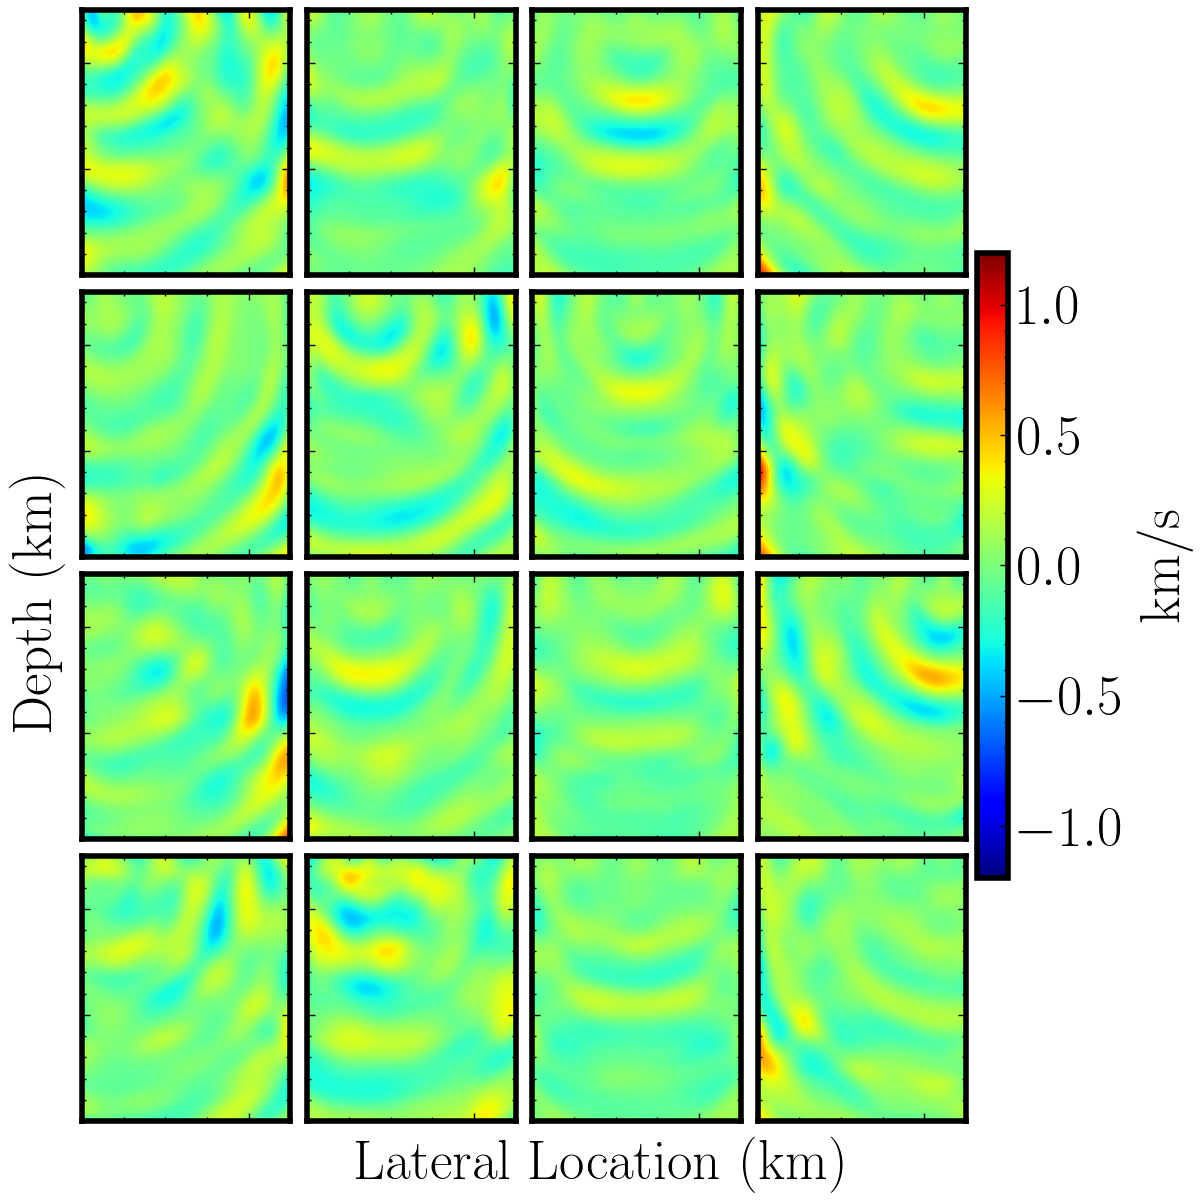

In [5]:
plot_square_image(dU_real_error,4,4, save_dir='../saves/', name='real_error_reseamt.pdf', vmin=-1.2, vmax=1.2, cmap='jet')

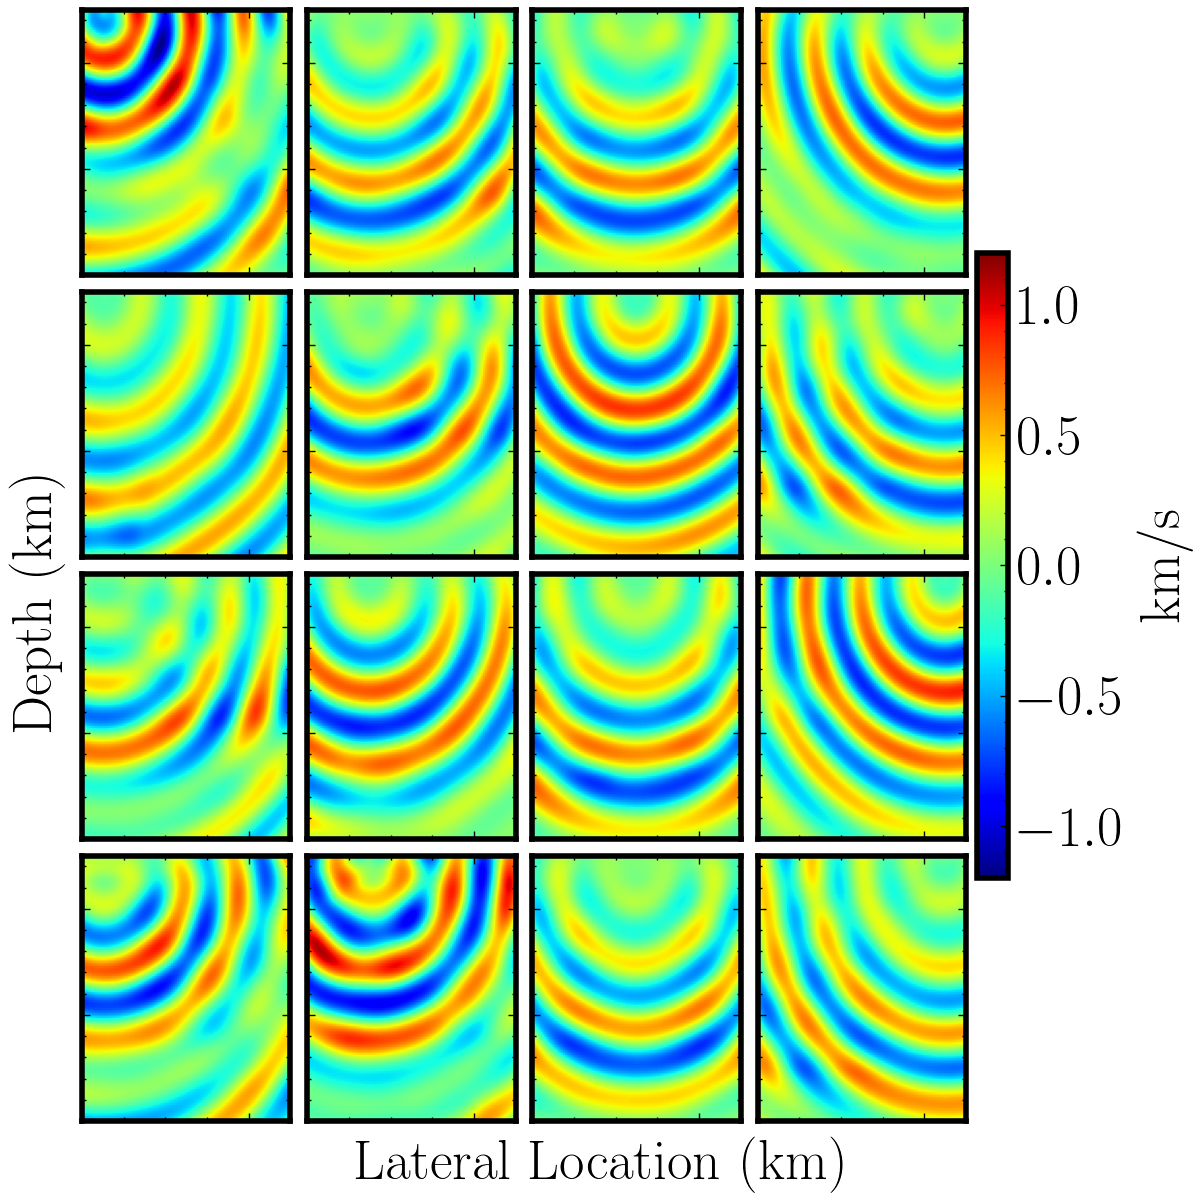

In [6]:
plot_square_image(dU_real_test,4,4, save_dir='../saves/', name='real_num_reseamt.pdf', vmin=-1.2, vmax=1.2, cmap='jet')

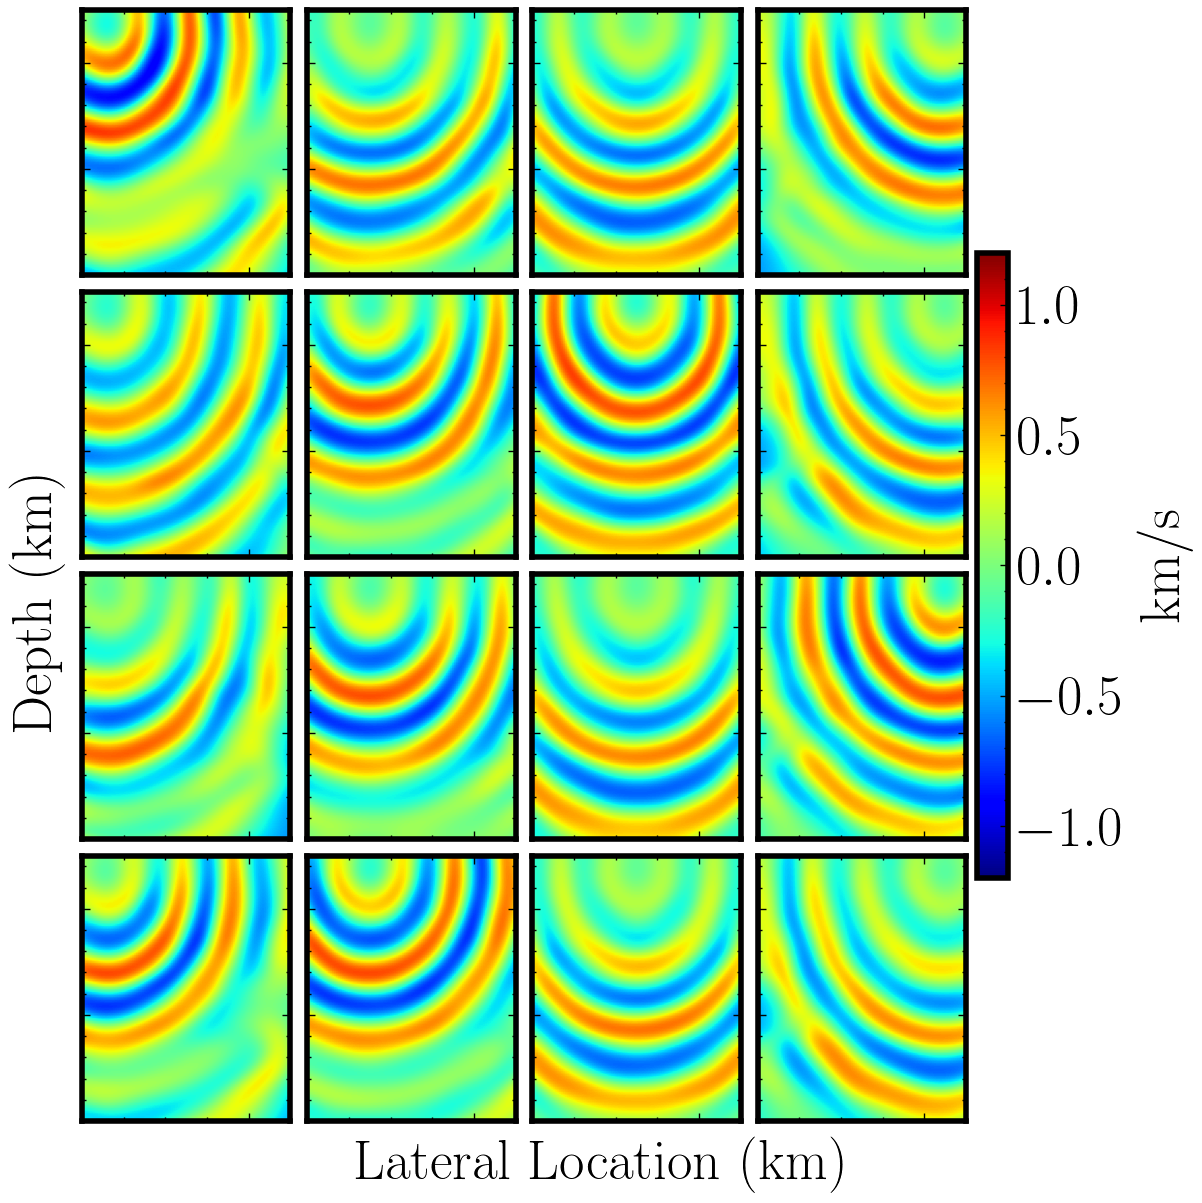

In [7]:
plot_square_image(dU_real_pred,4,4, save_dir='../saves/', name='real_pred_reseamt.pdf', vmin=-1.2, vmax=1.2, cmap='jet')